In [1]:
import os  # For directory and file operations
import numpy as np  # For numerical operations and handling image arrays
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from sklearn.utils import shuffle  # For shuffling the data

In [2]:
import os
from sklearn.utils import shuffle

# Corrected directory paths (missing closing quote in original)
train_dir = r'./computer_vision/Training/'
test_dir = r'./computer_vision/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)


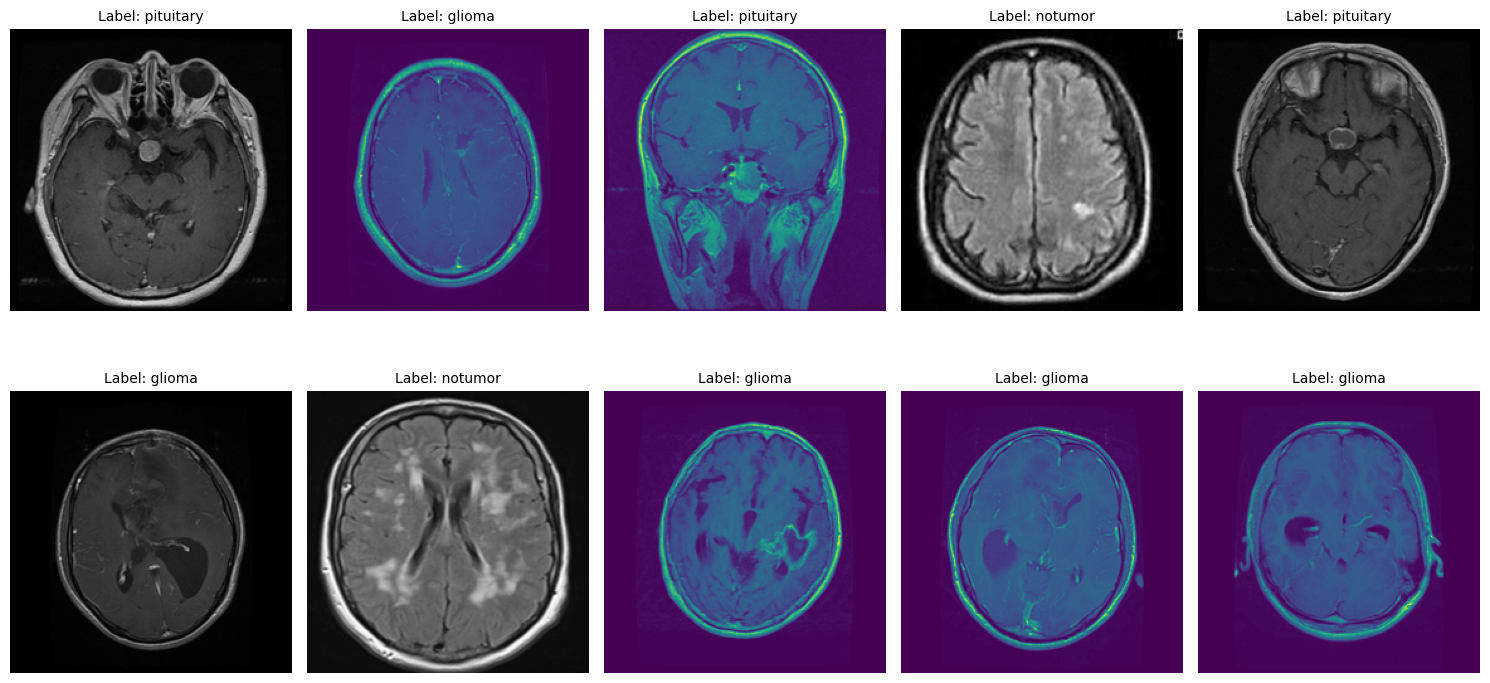

In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()


In [4]:
import numpy as np
import random
import os
from PIL import Image, ImageEnhance
from tensorflow.keras.utils import load_img, img_to_array

# Global constant for image size
IMAGE_SIZE = 128

# Get class labels once (avoid doing it inside generator)
class_labels = sorted(os.listdir(train_dir))  # sorted to keep consistency

# Augmentation function
def augment_image(image_array):
    image = Image.fromarray(np.uint8(image_array))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    return np.array(image) / 255.0  # Normalize to [0,1]

# Function to open and augment a batch of images
def open_and_augment_batch(paths):
    return np.array([
        augment_image(img_to_array(load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))))
        for path in paths
    ])

# Label encoding using precomputed label list
def encode_labels(label_batch):
    return np.array([class_labels.index(label) for label in label_batch])

# Generator function
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]

            X_batch = open_and_augment_batch(batch_paths)
            y_batch = encode_labels(batch_labels)

            yield X_batch, y_batch


Model training

In [5]:
#Added various model improvements like adding early stopping,modelcheckpoint,validation and callbacks, fine tuning with vgg16 gradually.

In [ ]:
# Train-val split
train_p, val_p, train_l, val_l = train_test_split(train_paths, train_labels, test_size=0.2, stratify=train_labels)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_vgg16_model.h5", save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Build Model
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Training
batch_size = 20
epochs = 20
steps_per_epoch = len(train_p) // batch_size
val_steps = len(val_p) // batch_size

history = model.fit(
    datagen(train_p, train_l, batch_size=batch_size, epochs=epochs),
    validation_data=datagen(val_p, val_l, batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=epochs,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# Plot Accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))


In [ ]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the entire model
model.save('model_v3.h5')

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('model_v3.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))


In [ ]:
# Example usage
image_path = './computer_vision/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)